# Aula 28 - Tensor Flow - Redes Neurais - Cifar10 
# VGG 3 - Weight Decay

<h2 style='color:blue' align='center'>Classificação de imagens pequenas usando rede neural convolucional (CNN)</h2>

Neste **notebook**, classificaremos conjuntos de dados **cifar10** de pequenas imagens a partir de conjuntos de dados tensorflow keras. <br />Há um total de 10 classes, conforme mostrado abaixo. <br />Usaremos CNN para classificação.

<img src="https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/small_images.jpg?raw=1" />

## Importações das bibliotecas

In [ ]:
import sys
import tensorflow as tf
from matplotlib import pyplot
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

## One Hot Encoding
A **tf.keras.utils.to_categorical**, converte um vetor de classe (inteiros) em uma matriz de classe binária.

Sabemos que existem **10 classes** e que as classes são representadas como **inteiros únicos**.

Podemos, portanto, usar uma codificação **one hot** para o elemento de classe de cada amostra, transformando o inteiro em um **vetor binário** de **10** elementos com **1** para o índice do valor da classe. 

Podemos fazer isso com a função **to_categorical()**.

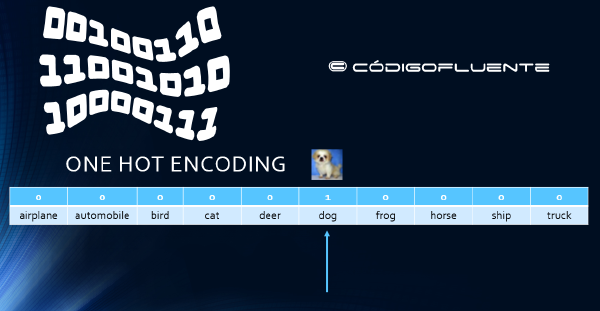

**OBS.** O uso do **One Hot Encoding** é para evitar que a rede aprenda com valores que não significam nada, como por exemplo, os inteiros que representam cada classe: 

**cachorro**(classe representada por **0**), **navio**(classe representada por **1**), **avião**(classe representada por **2**) e assim por diante.

Esses inteiros que representam essas classes não tem significado algum, são apenas rótulos, mas, o algorítmo pode achar que sim, e por exemplo, deduzir errôneamente que a **classe 1** é **menor** que a **classe 5**, e isso **não** é **verdade**.

Quando fazemos o **One Hot Encoding**, ele transforma essas classes em um vetor binário que não tem significado algum em termos de ordem, ou de valor, de forma a não confundir a rede na hora do treinamento.

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [ ]:
# call load dataset function
trainX, trainY, testX, testY = load_dataset()

In [ ]:
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

## Métrica  de teste para avaliação de modelo

O conjunto de dados **CIFAR-10** pode ser um ponto de partida útil para desenvolver e praticar uma metodologia para resolver problemas de classificação de imagens usando redes neurais convolucionais.

Em vez de revisar a literatura sobre modelos de bom desempenho no conjunto de dados, podemos desenvolver um novo modelo do zero.

O conjunto de dados já possui uma separação para treinamento e teste bem definido, usaremos essa separação já pronta. 

Uma alternativa pode ser realizar validação cruzada **k-fold** com **k = 5** ou **k = 10**. 

Isso é desejável se houver recursos suficientes, nesse caso, e no interesse de garantir que os exemplos neste tutorial sejam executados em um tempo razoável, não usaremos a validação cruzada **k-fold**.

Eles são o carregamento do conjunto de dados, a preparação do conjunto de dados, a definição do modelo, a avaliação do modelo e a apresentação dos resultados.

## Prepare os dados dos píxeis

Sabemos que os valores dos píxeis para cada imagem no conjunto de dados são inteiros sem sinal, no intervalo entre **sem cor** e **cor total**, ou **0** e **255**.

Não sabemos a melhor maneira de dimensionar os valores de cada píxel para modelagem, mas, sabemos que algum dimensionamento será necessário.

Um bom ponto de partida é normalizar os valores dos pixels, como já fizemos no exemplo anterior, então redimensione-os para o intervalo **[0,1]**.

Para isso, primeiro fazemos a conversão do tipo de dados de inteiros sem sinal em flutuantes e em seguida, a divisão dos valores de cada píxel pelo valor máximo.

A função **prep_pixels()** na célula abaixo, implementa esses comportamentos e é fornecida com os valores de pixel para os conjuntos de dados de trem e teste que precisarão ser dimensionados.

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

Esta função deve ser chamada para preparar os valores dos píxeis antes de qualquer modelagem.

In [ ]:
trainX, testX = prep_pixels(trainX, testX)

## Definir modelo

Em seguida, precisamos encontrar um modelo de rede neural.

A função **define_model()** na célula abaixo, irá definir e retornar este modelo.

Como desenvolver um modelo base, isto é, um base line.
Agora podemos investigar um modelo base para o conjunto de dados CIFAR-10.

Um base line estabelecerá um desempenho de modelo mínimo com o qual todos os nossos outros modelos podem ser comparados, bem como uma arquitetura de modelo que podemos usar como base de estudo e melhoria.

Um bom ponto de partida são os princípios gerais de arquitetura dos modelos VGG.

Estes são um bom ponto de partida porque obtiveram o melhor desempenho na competição ILSVRC 2014 e porque a estrutura modular da arquitetura é fácil de entender e implementar.

A arquitetura envolve o empilhamento de camadas convolucionais com pequenos filtros 3 × 3 seguidos por uma camada de agrupamento máximo.

Juntas, essas camadas formam um bloco e esses blocos podem ser repetidos, onde o número de filtros em cada bloco é aumentado com a profundidade da rede, como 32, 64, 128, 256 para os primeiros quatro blocos do modelo.

O preenchimento é usado nas camadas convolucionais para garantir que a altura e a largura dos mapas de recursos de saída correspondam às entradas.

Podemos explorar essa arquitetura no problema CIFAR-10 e comparar um modelo com essa arquitetura com 1, 2 e 3 blocos.

Cada camada usará a função de ativação ReLU e a inicialização de peso He, que geralmente são as melhores práticas.

## Linha base: **VGG - 3 blocos**.

A função **define_model()** para **VGG - 3 blocos**.

A arquitetura envolve o empilhamento de camadas convolucionais com pequenos filtros **3 × 3** seguidos por uma camada de **max pooling**, juntas, essas camadas formam um bloco e esses blocos podem ser repetidos onde o número de filtros em cada bloco é aumentado com a profundidade da rede, como **32**, **64**, **128**, **256** para os primeiros quatro blocos do modelo.

## Weight Decay ou Redução de peso

A regularização de redução do peso envolve a atualização da função de perda para penalizar o modelo em proporção ao tamanho dos pesos do modelo.

Isso tem um efeito de regularização, já que pesos maiores resultam em um modelo mais complexo e menos estável, enquanto pesos menores costumam ser mais estáveis e gerais.

Use a regularização de peso para reduzir overfitting de modelos de aprendizado profundo.

Podemos adicionar a regularização de peso às camadas convolucionais e às camadas totalmente conectadas definindo o argumento "kernel_regularizer" e especificando o tipo de regularização. 

Nesse caso, usaremos a regularização de peso L2, o tipo mais comum usado para redes neurais e um peso padrão sensível de 0,001.

O modelo de linha de base atualizado com redução de peso está listado abaixo.

In [ ]:
from keras.models import Sequential
from keras.regularizers import l2

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
 
	#bloco 1
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	#model.add(Dropout(0.2))
 
	#bloco 2
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	#model.add(Dropout(0.2))
 
  #bloco 3
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	#model.add(Dropout(0.2))
 
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
	#model.add(Dropout(0.2))
	model.add(Dense(10, activation=tf.nn.softmax, name='logits'))
	return model

In [ ]:
# define model
model = define_model()

In [ ]:
def train_model():
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(
        optimizer=opt, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)
    model.fit(
        x=trainX, 
        y=trainY,
        batch_size=100,
        epochs=100, 
        validation_data=(testX, testY), 
        callbacks=[tensorboard_callback])

train_model()

In [ ]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

Saída do código acima: 74,84 %

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Nota : Seus resultados podem variar devido à natureza estocástica do algoritmo ou procedimento de avaliação, ou diferenças na precisão numérica.

Considere executar o exemplo algumas vezes e compare o resultado médio.

Nesse caso, podemos ver que o modelo atingiu uma precisão de classificação de 74,84%.

Veja que as curvas seguem bem próximas até mais ou menos 10 épocas, depois disso, a precisão do modelo fica em torno do resultado final, 74,84% de acerto. 

Em relação ao Dropout, a técnica de regularização Weight Decay foi bem pior.

VGG3 + Weight Decay - 74,84%
VGG3 + Dropout - 82.33 %
